In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

#### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [4]:
data = df.resample('W').mean()

In [5]:
data.head(5)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


При недельном семплинге можно удалить ряд лишних признаков, относящихся к дням и часам, а также праздники

In [6]:
data.drop(['month', 'hour', 'year', 'dayofweek', 'dayofyear', 'dayofmonth', 'is_holiday','is_prev_holiday','is_next_holiday'], axis=1, inplace=True)

In [7]:
data.head(5)

,PJME_MW,quarter,weekofyear
Date,,,
2002-01-06,32392.160839,1.0,1.0
2002-01-13,31487.386905,1.0,2.0
2002-01-20,31452.880952,1.0,3.0
2002-01-27,30141.529762,1.0,4.0
2002-02-03,29196.488095,1.0,5.0


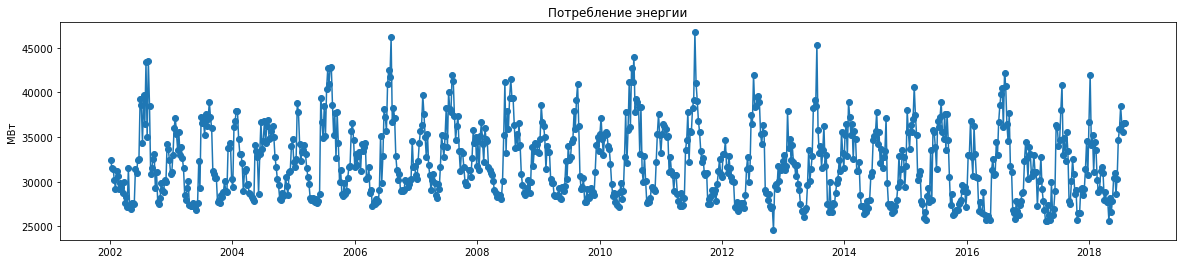

In [8]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], '-o' )
plt.title('Потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PJME_MW     866 non-null    float64
 1   quarter     866 non-null    float64
 2   weekofyear  866 non-null    float64
dtypes: float64(3)
memory usage: 27.1 KB


Разрывов в данных не видно 

#### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [10]:
# "Экспотенциальное сглаживание"
smoothing_steps = np.linspace(0.01, 0.09, 3).round(2)
smoothing_steps

array([0.01, 0.05, 0.09])

In [11]:
# Сглаживание 
for step in smoothing_steps:
     data['exp_'+str(step)] = exponential_smoothing(data['PJME_MW'], step)

In [12]:
# Первая разность
first_diff =np.array(data.iloc[1:,0].values - data.iloc[:-1,0].values).astype('float32') 
data['diff1'] = 0
data['diff1'] =  data['diff1'].astype('float') 
data['diff1'].values[1:] = first_diff
# или так data['diff1'] = data['PJME_MW'].diff(1)

In [13]:
# Скользящее  среднее с окном 52 недели (примерно год)
data['d_w52']= 0
data['d_w52']=data['PJME_MW'].rolling(window=52).mean()

In [14]:
# Скользящее  среднее с окном 4 недели 
data['d_w4']= 0
data['d_w4']=data['PJME_MW'].rolling(window=4).mean()

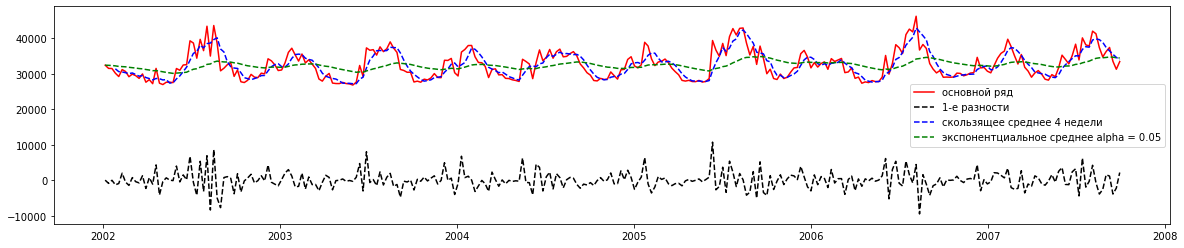

In [15]:
N=300  # диапазон графика, недель
plt.figure(figsize =(20,4))
plt.plot(data.index[:N],data['PJME_MW'][:N],'r',label ='основной ряд')
plt.plot(data.index[:N],data['diff1'][:N],'--k',label ='1-е разности')
plt.plot(data.index[:N],data['d_w4'][:N],'--b',label ='скользящее среднее 4 недели')
#plt.plot(data.index[:N],data['d_w52'][:N],'--o',label ='скользящее среднее год ')
plt.plot(data.index[:N],data['exp_0.05'][:N],'--g',label ='экспонентциальное среднее alpha = 0.05')
plt.legend()
plt.show()


In [16]:
data['diff1_d'] = data['diff1'] / data['PJME_MW']   # Нормирование первой разности
data['diff1_l'] = np.log(data['diff1'])  # Логорифмировние первой разницы
data.fillna(0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
# Формируем историю глубиной p, в том числе для первых разностей
p = 27
for i in range(p):
    data['t'+str(p-i)]=0
    data['t'+str(p-i)].values[p:] = data['PJME_MW'].values[i:-(p)+i]

for i in range(p):
    data['d'+str(p-i)]=0
    data['d'+str(p-i)].values[p:] = data['diff1'].values[i:-(p)+i]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 65 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PJME_MW     866 non-null    float64
 1   quarter     866 non-null    float64
 2   weekofyear  866 non-null    float64
 3   exp_0.01    866 non-null    float64
 4   exp_0.05    866 non-null    float64
 5   exp_0.09    866 non-null    float64
 6   diff1       866 non-null    float64
 7   d_w52       866 non-null    float64
 8   d_w4        866 non-null    float64
 9   diff1_d     866 non-null    float64
 10  diff1_l     866 non-null    float64
 11  t27         866 non-null    int64  
 12  t26         866 non-null    int64  
 13  t25         866 non-null    int64  
 14  t24         866 non-null    int64  
 15  t23         866 non-null    int64  
 16  t22         866 non-null    int64  
 17  t21         866 non-null    int64  
 18  t20         866 non-null    int64  
 19

In [19]:
data.head(28)

,PJME_MW,quarter,weekofyear,exp_0.01,exp_0.05,exp_0.09,diff1,d_w52,d_w4,diff1_d,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.0,1.0,32392.160839,32392.160839,32392.160839,0.000000,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,1.0,2.0,32383.113100,32346.922142,32310.731185,-904.773926,0.0,0.000000,-0.028734,...,0,0,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,1.0,3.0,32373.810778,32302.220083,32233.524664,-34.505951,0.0,0.000000,-0.001097,...,0,0,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,1.0,4.0,32351.487968,32194.185567,32045.245123,-1311.351196,0.0,31368.489615,-0.043506,...,0,0,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,1.0,5.0,32319.937969,32044.300693,31788.856990,-945.041687,0.0,30569.571429,-0.032368,...,0,0,0,0,0,0,0,0,0,0
2002-02-10,31150.517857,1.0,6.0,32308.243768,31999.611551,31731.406468,1954.029785,0.0,30485.354167,0.062729,...,0,0,0,0,0,0,0,0,0,0
2002-02-17,30616.565476,1.0,7.0,32291.326985,31930.459248,31631.070779,-533.952393,0.0,30276.275298,-0.017440,...,0,0,0,0,0,0,0,0,0,0
2002-02-24,29144.130952,1.0,8.0,32259.855025,31791.142833,31407.246195,-1472.434570,0.0,30026.925595,-0.050523,...,0,0,0,0,0,0,0,0,0,0
2002-03-03,29869.011905,1.0,9.0,32235.946594,31695.036287,31268.805109,724.880981,0.0,30195.056548,0.024269,...,0,0,0,0,0,0,0,0,0,0


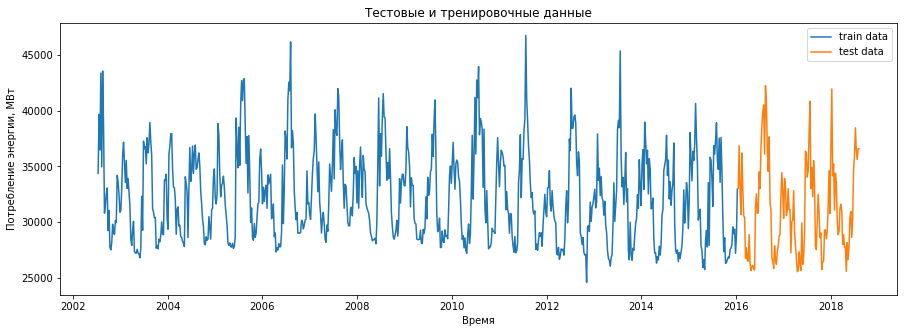

In [20]:
h = 4
train, test = split_data( data[p:], '15-01-2016' )
X_train_h4 = train.iloc[:-h, :]
y_train_h4 = train['PJME_MW'].values[h:]
X_test_h4 = test.iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]
plt.figure( figsize=( 15, 5 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

In [22]:
model_h4 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [23]:
model_h4.fit( X_train_h4, y_train_h4 )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [24]:
y_test_pred_h4 = model_h4.predict(X_test_h4)

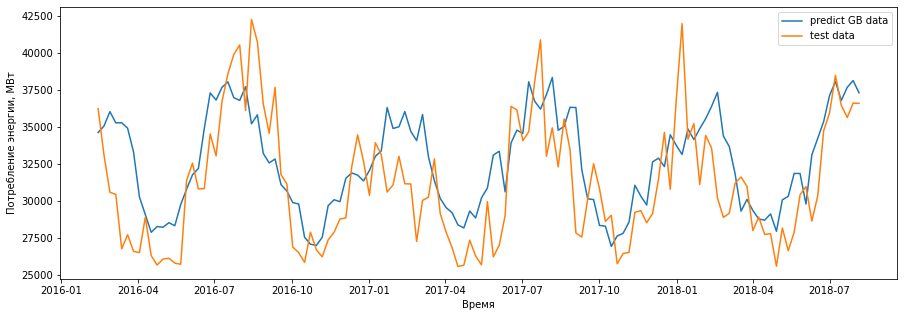

In [25]:
plt.figure( figsize=( 15, 5 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h:],y_test_pred_h4, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [26]:
mean_absolute_percentage_error(y_test, y_test_pred_h4)

8.705883572973109

In [27]:
from sklearn.feature_selection import SelectFromModel

In [28]:
params = SelectFromModel(model_h4, max_features=8)

In [29]:
params.fit(X_train_h4, y_train_h4)

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9,
                                                    criterion='friedman_mse',
                                                    init=None,
                                                    learning_rate=0.1,
                                                    loss='ls', max_depth=5,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                                                    

In [30]:
best_fes = data.columns[np.where(params.get_support())[0]]
best_fes

Index(['PJME_MW', 'weekofyear', 'd_w4', 't23', 't22', 't10', 't9', 't8'], dtype='object')

#### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [31]:
h = 1
train, test = split_data( data[p:], '15-01-2016' )
X_train = train.iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]

model_h1 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_h1.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [32]:
y_test_pred_h1 = model_h1.predict(X_test)

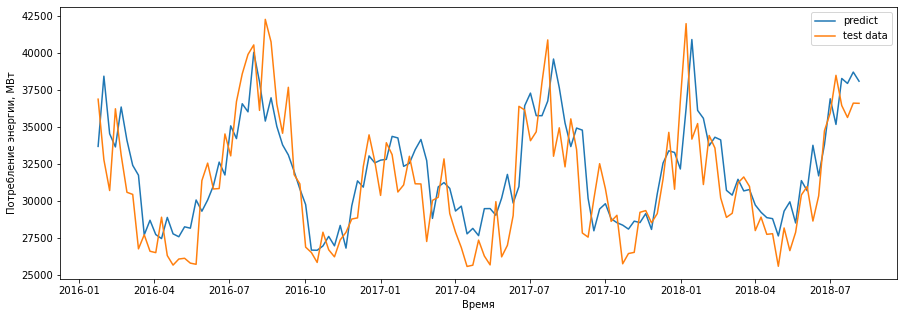

In [33]:
plt.figure( figsize=( 15, 5 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h:],y_test_pred_h1, label='predict' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [34]:
mean_absolute_percentage_error(y_test, y_test_pred_h1) 

6.846953287082112

#### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 

In [35]:
best_fes

Index(['PJME_MW', 'weekofyear', 'd_w4', 't23', 't22', 't10', 't9', 't8'], dtype='object')

In [36]:
num_best_fes=np.where(params.get_support())[0]
num_best_fes

array([ 0,  2,  8, 15, 16, 28, 29, 30], dtype=int64)

In [37]:
h = 1
X_train = train[best_fes].iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test[best_fes].iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [38]:
n = X_test.shape[0]
print(n)
X_test_ar = X_test.copy()
y_test_ar = y_test.copy()

133


In [39]:
for i in range(0,n):
    if i<23 :  # т.к. максимальная глубина опорных данных (истории) 23 недели
        y_test_ar[i] = model_gb.predict(X_test_ar.iloc[i:i+1, :])
    else:
        y_test_ar[i] = model_gb.predict(X_test_ar.iloc[i:i+1, :])
        X_test_ar.iloc[i, 0] = y_test_ar[i]
        X_test_ar.iloc[i, 2] = X_test_ar.iloc[i-4:i,2].mean()
        X_test_ar.iloc[i, 3] = y_test_ar[i-23]
        X_test_ar.iloc[i, 4] = y_test_ar[i-22]
        X_test_ar.iloc[i, 5] = y_test_ar[i-10]
        X_test_ar.iloc[i, 6] = y_test_ar[i-9]
        X_test_ar.iloc[i, 7] = y_test_ar[i-8]
        

In [40]:
h = 4
X_train = train[best_fes].iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test[best_fes].iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)
y_test_pred = model_gb.predict(X_test)

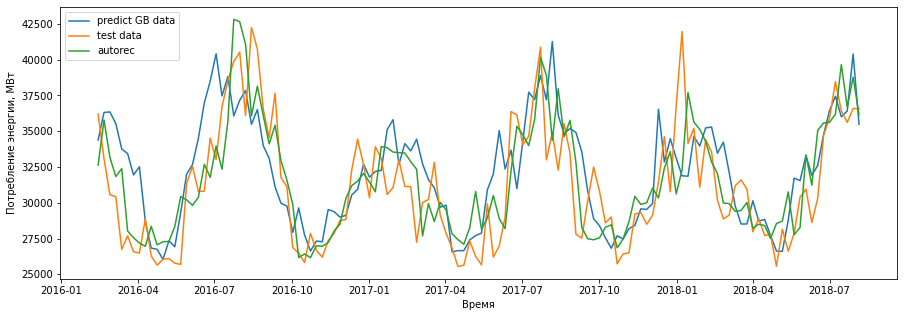

In [41]:
plt.figure( figsize=( 15, 5 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h:],y_test_pred, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(test.index[h:],y_test_ar[h-1:], label='autorec')

plt.legend()
plt.show()

In [42]:
mean_absolute_percentage_error(y_test, y_test_ar[h-1:]), mean_absolute_percentage_error(y_test, y_test_pred), 

(6.380245085589739, 8.052411711031954)

#### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

In [43]:
error_ar = []
error = []
for i in range(0, 100, 10):
    error.append(mean_absolute_percentage_error(y_test[i:i+9], y_test_pred[i:i+9])) 
    error_ar.append(mean_absolute_percentage_error(y_test[i:i+9], y_test_ar[i:i+9])) 

error_ar

[14.059355102874632,
 6.4598827113916455,
 10.127719705674679,
 12.553777893309764,
 7.292259265191192,
 7.769272913659381,
 8.756525354037887,
 12.469419285591139,
 12.149946952958139,
 7.060225001446513]

#### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда

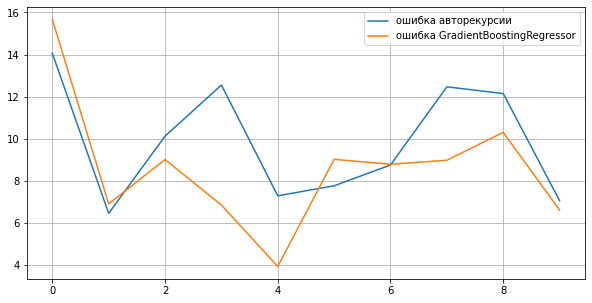

In [44]:
plt.figure(figsize=(10,5))
plt.plot(error_ar, label='ошибка авторекурсии')
plt.plot(error, label='ошибка GradientBoostingRegressor')
plt.legend()
plt.grid()

Странно, но ошибка снижается, НЕ ОСОЗНАЮ (((((((